In [1]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=d9b3d35985faf5a3c389d4fd42835513f0ccced1cc17878bdd3edc867b255cac
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import pandas as pd
import scipy.stats as sstats
import pingouin
%matplotlib inline

In [4]:
plt.rcParams['font.size'] = 7
plt.rcParams["axes.unicode_minus"] = False

In [5]:
# this is for Zhen-Qi, change it when you run it
data_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [ ]:
# this is for Haley
data_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [6]:
ep_pls_loadings = h5py.File(data_dir / "EP_pls_loadings.hdf5")
mend_pls_loadings = h5py.File(data_dir / "MEND_pls_loadings.hdf5")

ep_pls_res = h5py.File(data_dir / "EP_pls_result.hdf5")
mend_pls_res = h5py.File(data_dir / "MEND_pls_result.hdf5")

In [7]:
ep_x_loadings = ep_pls_loadings["results/y_loadings"]
mend_x_loadings = mend_pls_loadings["results/y_loadings"]

In [8]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [9]:

from matplotlib.colors import ListedColormap, to_rgb, to_hex
xload_name2color = {
    "FA": "#F19100",
    "MD": "#305861",
    "AD": "#31A9E7",
    "RD": "#5C554A"
}
xload_names = list(xload_name2color.keys())
xload_colors = list(xload_name2color.values())
cmap_xload = ListedColormap([to_rgb(_) for _ in xload_colors])

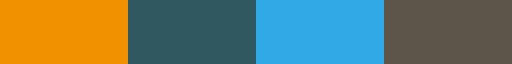

In [10]:
cmap_xload

In [16]:
diff_pred_names = np.loadtxt(data_dir / "JHU_labels.txt", delimiter="\t", dtype=str)
diff_pred_colors = [xload_names.index(_.split("_")[0]) for _ in diff_pred_names]
# diff_pred_colors

In [17]:
classified_tracts = pd.read_csv(data_dir / "classified_tracts_w_coefs.csv")
classified_tracts["combined_ci"] = (classified_tracts["EP_CI"] > 0).astype(int) + (classified_tracts["MEND_CI"] > 0).astype(int)

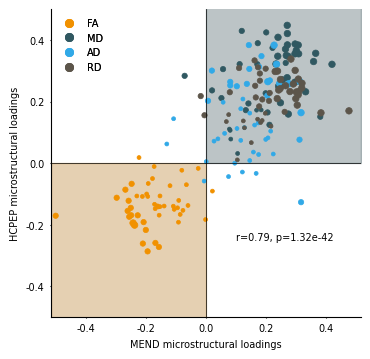

In [22]:
score_corr_r, score_corr_p = sstats.pearsonr(-1 * mend_x_loadings[:, 0], ep_x_loadings[:, 0])


fig, ax = plt.subplots(figsize=(4, 4))
scatter = ax.scatter(-1 * mend_x_loadings[:, 0], ep_x_loadings[:, 0],
           c=diff_pred_colors, s=8 + classified_tracts["combined_ci"] * 7, cmap=cmap_xload, linewidths=0.5, clip_on=False) #edgecolors='white'

ax.axvline(x=0, c="k", linewidth=0.5)#, zorder=0.5, ls=(0, (2, 1)))
ax.axhline(y=0, c="k", linewidth=0.5)#, zorder=0.7, ls=(0, (2, 1)))

ax.fill_between([0, 0.517], [0.517, 0.517], [0, 0], color=to_hex(scale_lightness(to_rgb(xload_colors[1]), 0.7)), zorder=0.5, alpha=0.3)
ax.fill_between([-0.517, 0], [0, 0], [-0.517, -0.517], color=to_hex(scale_lightness(to_rgb(xload_colors[0]), 0.7)), zorder=0.5, alpha=0.3)

# reg_x = np.arange(-20, np.max(ep_pls_result["results"]["x_scores"][:, 0]), 0.1)
#ax.plot(reg_x, m * reg_x + b, color="gray", zorder=0.5)

ax.set(xlim=(-0.517, 0.517), ylim=(-0.5, 0.5), xticks=[-0.4, -0.2, 0, 0.2, 0.4], yticks=[-0.4, -0.2, 0, 0.2, 0.4],
       xlabel="MEND microstructural loadings", ylabel="HCPEP microstructural loadings")

ax.text(0.1, -0.25, f"r={score_corr_r:.2f}, p={score_corr_p:.2e}")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

handles, previous_labels = scatter.legend_elements()
legend = ax.legend(handles=handles, labels=xload_names, loc="upper left", bbox_to_anchor=(0, 1.0), frameon=False)
ax.add_artist(legend)

fig.savefig(figs_dir / "mend_hcpep_xload_corr.svg")

In [ ]:
 mend_pred_X_composite = mend_pls_res["results/inputs/X"][:] @ (-1 * ep_pls_res["results/x_weights"][:])

In [ ]:
import statsmodels.api as sm

In [ ]:
lm_xscore = pingouin.linear_regression(mend_pls_res["results/x_scores"][:, 0], mend_pred_X_composite[:, 0])
lm_xscore

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.304949e-16,0.138838,2.380441e-15,1.000000e+00,0.97757,0.977214,-0.277445,0.277445
1,x1,9.939212e-01,0.018968,5.239997e+01,1.138546e-53,0.97757,0.977214,0.956017,1.031826


In [ ]:
# replication with statsmodels
X = sm.add_constant(mend_pls_res["results/x_scores"][:, 0])
y = mend_pred_X_composite[:, 0]
re_xscore = sm.OLS(y, X).fit()
re_xscore.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2746.
Date:                Thu, 10 Aug 2023   Prob (F-statistic):           1.14e-53
Time:                        02:36:08   Log-Likelihood:                -98.544
No. Observations:                  65   AIC:                             201.1
Df Residuals:                      63   BIC:                             205.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.24e-16      0.139   1.61e-15      1.000      -0.277       0.277
x1             0.9939      0.019     52.400      0.000       0.956       1.032
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.530
Skew:                          -0.179   Prob(JB):                        0.767
Kurtosis:                       2.740   Cond. No.                         7.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_yscore = pingouin.linear_regression(mend_pls_res["results/y_scores"][:, 0], mend_pred_X_composite[:, 0])
lm_yscore

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.304949e-16,0.872903,3.786160e-16,1.000000,0.113369,0.099295,-1.744357,1.744357
1,x1,9.965624e-01,0.351123,2.838213e+00,0.006098,0.113369,0.099295,0.294899,1.698226


In [ ]:
# replication with statsmodels
X = sm.add_constant(mend_pls_res["results/y_scores"][:, 0])
y = mend_pred_X_composite[:, 0]
re_yscore = sm.OLS(y, X).fit()
re_yscore.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     8.055
Date:                Thu, 10 Aug 2023   Prob (F-statistic):            0.00610
Time:                        02:36:10   Log-Likelihood:                -218.05
No. Observations:                  65   AIC:                             440.1
Df Residuals:                      63   BIC:                             444.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.24e-16      0.873   2.57e-16      1.000      -1.744       1.744
x1             0.9966      0.351      2.838      0.006       0.295       1.698
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   2.540
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.359
Skew:                           0.181   Prob(JB):                        0.836
Kurtosis:                       2.957   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# re_yscore.rsquared
re_yscore.pvalues

array([1.        , 0.00609766])

In [ ]:
# plotting regression confidence intervals
# https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels/47191929

<ipython-input-25-ba69c05bb73e>:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(-20, 20), ylim=(20, 20), xticks=[-20, -10, 0, 10, 20], yticks=[-20, -10, 0, 10, 20],


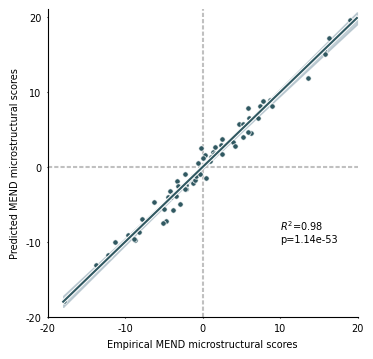

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
scatter = ax.scatter(mend_pls_res["results/x_scores"][:, 0], mend_pred_X_composite[:, 0],
           s=15, c="#305861", linewidths=0.5, edgecolors='white')
ax.axvline(x=0, c="silver", zorder=0.7, ls=(0, (2, 1)))
ax.axhline(y=0, c="silver", zorder=0.7, ls=(0, (2, 1)))

regline_x = np.arange(-18, 20, 0.1)
regline_y = lm_yscore.loc[1, "coef"] * regline_x + lm_yscore.loc[0, "coef"]

ax.plot(regline_x, regline_y, lw=1.5, color="#305861", path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])

predictions = re_xscore.get_prediction(sm.add_constant(regline_x))
pred_summary = predictions.summary_frame(alpha=0.05)
ax.fill_between(regline_x, pred_summary["mean_ci_upper"], pred_summary["mean_ci_lower"], color="#A9BBC5", zorder=0, alpha=0.7)

ax.set(xlim=(-20, 20), ylim=(20, 20), xticks=[-20, -10, 0, 10, 20], yticks=[-20, -10, 0, 10, 20],
       xlabel="Empirical MEND microstructural scores", ylabel="Predicted MEND microstructural scores")

ax.text(10, -10, f"$R^2$={re_xscore.rsquared:.2f}\np={re_xscore.pvalues[1]:.2e}")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

fig.savefig(figs_dir / "mend_pred_xscore.svg")

<Axes: >

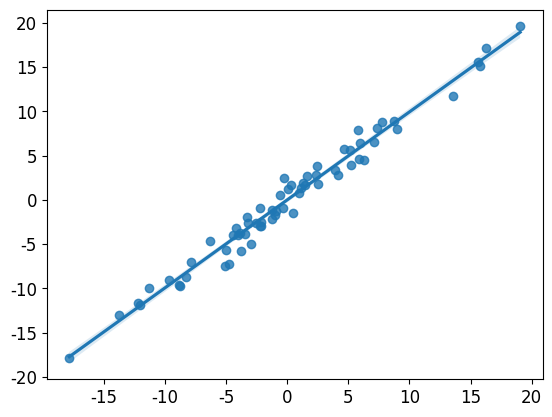

In [ ]:
# this is only for reference to check the CI plotting
sns.regplot(x=mend_pls_result["results/x_scores"][:, 0], y=mend_pred_X_composite[:, 0], ci=95)

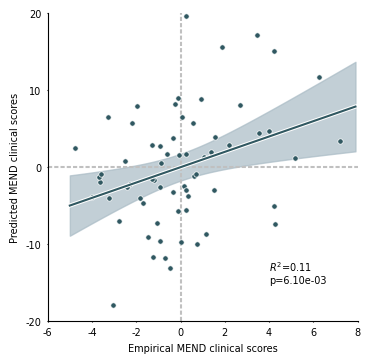

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
scatter = ax.scatter(mend_pls_res["results/y_scores"][:, 0], mend_pred_X_composite[:, 0],
           s=15, c="#305861", linewidths=0.5, edgecolors='white')
ax.axvline(x=0, c="silver", zorder=0.7, ls=(0, (2, 1)))
ax.axhline(y=0, c="silver", zorder=0.7, ls=(0, (2, 1)))

regline_x = np.arange(-5, 8, 0.1)
regline_y = lm_yscore.loc[1, "coef"] * regline_x + lm_yscore.loc[0, "coef"]

ax.plot(regline_x, regline_y, lw=1.5, color="#305861", path_effects=[pe.Stroke(linewidth=3, foreground='white'), pe.Normal()])

predictions = re_yscore.get_prediction(sm.add_constant(regline_x))
pred_summary = predictions.summary_frame(alpha=0.05)
ax.fill_between(regline_x, pred_summary["mean_ci_upper"], pred_summary["mean_ci_lower"], color="#A9BBC5", zorder=0, alpha=0.7)

ax.set(xlim=(-6, 8), ylim=(-20, 20), xticks=[-6, -4, -2, 0, 2, 4, 6, 8], yticks=[-20, -10, 0, 10, 20],
       xlabel="Empirical MEND clinical scores", ylabel="Predicted MEND clinical scores")

ax.text(4, -15, f"$R^2$={re_yscore.rsquared:.2f}\np={re_yscore.pvalues[1]:.2e}")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

fig.savefig(figs_dir / "mend_pred_yscore.svg")

<Axes: >

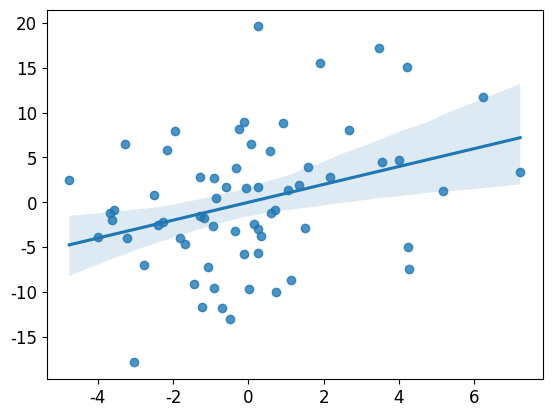

In [ ]:
# this is only for reference to check the CI plotting
sns.regplot(x=mend_pls_result["results/y_scores"][:, 0], y=mend_pred_X_composite[:, 0], ci=95)

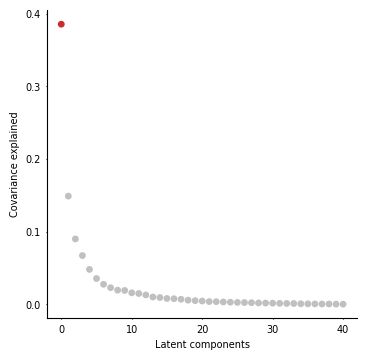

In [ ]:
ep_varexp = ep_pls_res["results/varexp"][:]
ep_varexp_pval = ep_pls_res["results/permres/pvals"][:]
ep_varexp_pval_color = ["tab:red" if p<=0.05 else "silver" for p in ep_varexp_pval]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(range(len(ep_varexp)), ep_varexp, s=15, c=ep_varexp_pval_color)

ax.set(xticks=[0, 10, 20, 30, 40], yticks=[0, 0.1, 0.2, 0.3, 0.4],
       xlabel="Latent components", ylabel="Covariance explained")

# pax = ax.twinx()
# pax.scatter(range(len(ep_varexp)), ep_varexp_pval, s=10, c="tab:orange")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

fig.savefig(figs_dir / "ep_pls_varexp.svg")

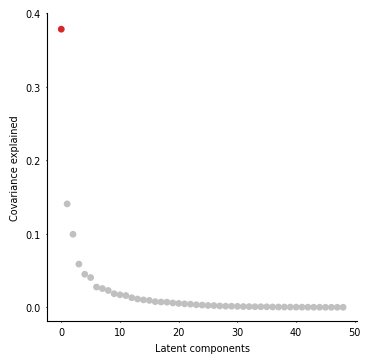

In [ ]:
mend_varexp = mend_pls_res["results/varexp"][:]
mend_varexp_pval = mend_pls_res["results/permres/pvals"][:]
mend_varexp_pval_color = ["tab:red" if p<=0.05 else "silver" for p in mend_varexp_pval]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(range(len(mend_varexp)), mend_varexp, s=15, c=mend_varexp_pval_color)

ax.set(xticks=[0, 10, 20, 30, 40, 50], yticks=[0, 0.1, 0.2, 0.3, 0.4],
       xlabel="Latent components", ylabel="Covariance explained")

sns.despine(top=True, right=True, trim=False, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

fig.savefig(figs_dir / "mend_pls_varexp.svg")